# Taking Full Advantage of Parallelism With Data Distribution
_**Using Amazon SageMaker's Managed, Distributed Training with Different Data Distribution Methods**_

---

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
  1. [Scaling](#Scaling)
1. [Train](#Train)
  1. [Timing](#Timing)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)
1. [Extensions](#Extensions)


## Background

Amazon SageMaker makes it easy to train machine learning models across a large number of machines.  This a non-trivial process, but Amazon SageMaker Algorithms and pre-built MXNet and TensorFlow containers hide most of the complexity from you.  Nevertheless, there are decisions on how a user structures their data which will have an implication on how the distributed training is carried out.  This notebook will walk through details on setting up your data to take full advantage of distributed processing.

---
# Setup

_This notebook was created and tested on an ml.m4.xlarge notebook instance._

Let's start by specifying:

- The S3 bucket and prefix that you want to use for training and model data.  This should be within the same region as the Notebook Instance, training, and hosting.
- The IAM role arn used to give training and hosting access to your data. See the documentation for how to create these.  Note, if more than one role is required for notebook instances, training, and/or hosting, please replace the boto regexp with a the appropriate full IAM role arn string(s).

In [37]:
!pip install pandas==1.0.5

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 10.1 MB 28.9 MB/s            
  Attempting uninstall: pandas
    Found existing installation: pandas 1.0.1
    Uninstalling pandas-1.0.1:
      Successfully uninstalled pandas-1.0.1


In [1]:
import sagemaker

sess = sagemaker.Session()

bucket = sess.default_bucket()

# S3 bucket and prefix
# bucket = "<your_s3_bucket_name_here>"
prefix = "sagemaker/DEMO-data-distribution-types"

# Define IAM role
import boto3
import re
from sagemaker import get_execution_role

role = get_execution_role()

Next, we'll import the Python libraries we'll need for the remainder of the exercise.

In [2]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
import io
import time
import copy
import json
import sys
import sagemaker.amazon.common as smac
import os

---

## Data

The [dataset](https://aws.amazon.com/public-datasets/gdelt/) we'll use for this notebook is from the [Global Database of Events, Language and Tone (GDELT) Project](https://www.gdeltproject.org/).  This information is freely available on S3 as part of the [AWS Public Datasets](https://aws.amazon.com/public-datasets/) program.

The data are stored as multiples files on S3, with two different formats: historical, which covers from 1979 to 2013, and daily updates which covers from 2013 on.  For this example, we'll stick to historical.  Let's bring in 1979 data for the purpose of interactive exploration.  We'll write a simple function so that later we can use it to download multiple files.

In [3]:
def get_gdelt(filename):
    s3 = boto3.resource("s3")
    s3.Bucket("gdelt-open-data").download_file("events/" + filename, ".gdelt.csv")
    df = pd.read_csv(".gdelt.csv", sep="\t")
    header = pd.read_csv(
        "https://www.gdeltproject.org/data/lookups/CSV.header.historical.txt", sep="\t"
    )
    df.columns = header.columns
    return df

In [4]:
data = get_gdelt("1979.csv")
data

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


,GLOBALEVENTID,SQLDATE,MonthYear,Year,FractionDate,Actor1Code,Actor1Name,Actor1CountryCode,Actor1KnownGroupCode,Actor1EthnicCode,...,Actor2Geo_Long,Actor2Geo_FeatureID,ActionGeo_Type,ActionGeo_FullName,ActionGeo_CountryCode,ActionGeo_ADM1Code,ActionGeo_Lat,ActionGeo_Long,ActionGeo_FeatureID,DATEADDED
0,1,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,8.0000,0,1.0,Nigeria,NI,NI,10.0000,8.0000,0.0,20130203
1,2,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,8.0000,0,1.0,Nigeria,NI,NI,10.0000,8.0000,0.0,20130203
2,3,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,106.3590,-1903584,4.0,"Dizhou, Guangxi, China",CH,CH16,23.0036,106.3590,-1903584.0,20130203
3,4,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,-96.8067,1380944,3.0,"Dallas, Texas, United States",US,USTX,32.7831,-96.8067,1380944.0,20130203
4,5,19790101,197901,1979,1979.0027,NaN,NaN,NaN,NaN,NaN,...,34.6809,-779676,4.0,"Emunim, HaDarom, Israel",IS,IS01,31.7444,34.6809,-779676.0,20130203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
430935,230397975,19791231,197912,1979,1979.9890,USA,UNITED STATES,USA,NaN,NaN,...,51.5148,10074674,4.0,"Tehran, Tehran, Iran",IR,IR26,35.7500,51.5148,10074674.0,20130206
430936,230397976,19791231,197912,1979,1979.9890,USA,UNITED STATES,USA,NaN,NaN,...,51.5148,10074674,4.0,"Tehran, Tehran, Iran",IR,IR26,35.7500,51.5148,10074674.0,20130206
430937,230397977,19791231,197912,1979,1979.9890,USA,WASHINGTON,USA,NaN,NaN,...,65.0000,-2089022,4.0,"Moscow, Moskva, Russia",RS,RS48,55.7522,37.6156,-2960561.0,20130206
430938,230397978,19791231,197912,1979,1979.9890,VNM,VIETNAM,VNM,NaN,NaN,...,0.0000,0,1.0,France,FR,FR,46.0000,2.0000,0.0,20130206


As we can see, there are 57 columns, some of which are sparsely populated, cryptically named, and in a format that's not particularly friendly for machine learning.  So, for our use case, we'll strip down to a few core attributes.  We'll use:

- `EventCode`: This is the raw CAMEO action code describing the action that Actor1 performed upon Actor2.  More detail can be found [here](https://www.gdeltproject.org/data/documentation/CAMEO.Manual.1.1b3.pdf)
- `NumArticles`:  This is the total number of source documents containing one or more mentions of this event. This can be used as a method of assessing the “importance” of an event; the more discussion of that event, the more likely it is to be significant
- `AvgTone`: This is the average “tone” of all documents containing one or more mentions of this event. The score ranges from -100 (extremely negative) to +100 (extremely positive). Common values range between -10 and +10, with 0 indicating neutral.
- `Actor1Geo_Lat`: This is the centroid latitude of the Actor1 landmark for mapping.
- `Actor1Geo_Long`: This is the centroid longitude of the Actor1 landmark for mapping.
- `Actor2Geo_Lat`: This is the centroid latitude of the Actor2 landmark for mapping.
- `Actor2Geo_Long`: This is the centroid longitude of the Actor2 landmark for mapping.

In [5]:
data = data[
    [
        "EventCode",
        "NumArticles",
        "AvgTone",
        "Actor1Geo_Lat",
        "Actor1Geo_Long",
        "Actor2Geo_Lat",
        "Actor2Geo_Long",
    ]
]

data["EventCode"] = data["EventCode"].astype(int)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


,EventCode,NumArticles,AvgTone,Actor1Geo_Lat,Actor1Geo_Long,Actor2Geo_Lat,Actor2Geo_Long
count,430940.000000,430940.000000,430940.000000,430940.000000,430940.000000,430940.000000,430940.000000
mean,92.385571,4.369694,5.127215,26.311911,26.111038,23.109048,23.637813
std,172.919307,3.121310,2.637798,21.865323,61.125843,22.136466,57.693612
min,10.000000,1.000000,0.000000,-85.622100,-179.050000,-85.622100,-179.050000
25%,40.000000,2.000000,3.333333,10.000000,0.000000,0.000000,0.000000
50%,43.000000,4.000000,5.000000,32.000000,28.229400,30.044500,19.500000
75%,100.000000,6.000000,6.666667,40.400000,53.000000,39.928900,50.093800
max,1832.000000,54.000000,28.571429,85.000000,180.000000,85.000000,180.000000


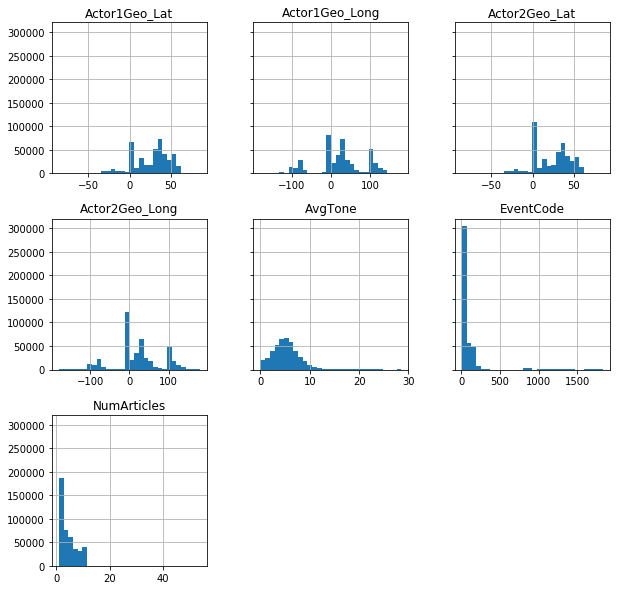

In [6]:
for column in data.select_dtypes(include=["object"]).columns:
    display(pd.crosstab(index=data[column], columns="% observations", normalize="columns"))

display(data.describe())
hist = data.hist(bins=30, sharey=True, figsize=(10, 10))
plt.show()

We can see:
- `EventCode` is pretty unevenly distributed, with some events making up 7%+ of the observations and others being a thousandth of a percent.
- `AvgTone` seems to be reasonably smoothly distributed, while `NumArticles` has a long tail, and `Actor` geo features have suspiciously large spikes near 0.

Let's remove the (0, 0) lat-longs, one hot encode `EventCode`, and prepare our data for a machine learning model.  For this example we'll keep things straightforward and try to predict `AvgTone`, using the other variables in our dataset as features.

One more issue remains.  As we noticed above, some occurrences of `EventCode` are very rare, and may be unlikely to occur in every single year.  This means if we one hot encode individual years at a time, our feature matrix may change shape over the years, which will not work.  Therefore, we'll limit all years to the most common `EventCodes` from the year we current have.  Let's get this list.

In [7]:
events = (
    pd.crosstab(index=data["EventCode"], columns="count")
    .sort_values(by="count", ascending=False)
    .index[:20]
)

### Scaling

Now that we've explored our data and are ready to prepare for modeling, we can start developing a few simple functions to help us scale this to GDELT datasets from other years.

In [8]:
def write_to_s3(bucket, prefix, channel, file_prefix, X, y):
    buf = io.BytesIO()
    smac.write_numpy_to_dense_tensor(buf, X.astype("float32"), y.astype("float32"))
    buf.seek(0)
    boto3.Session().resource("s3").Bucket(bucket).Object(
        os.path.join(prefix, channel, file_prefix + ".data")
    ).upload_fileobj(buf)


def transform_gdelt(df, events=None):
    df = df[
        [
            "AvgTone",
            "EventCode",
            "NumArticles",
            "Actor1Geo_Lat",
            "Actor1Geo_Long",
            "Actor2Geo_Lat",
            "Actor2Geo_Long",
        ]
    ]
    df["EventCode"] = df["EventCode"].astype(object)
    if events is not None:
        df = df[np.in1d(df["EventCode"], events)]
    return pd.get_dummies(
        df[
            ((df["Actor1Geo_Lat"] == 0) & (df["Actor1Geo_Long"] == 0) != True)
            & ((df["Actor2Geo_Lat"] == 0) & (df["Actor2Geo_Long"] == 0) != True)
        ]
    )


def prepare_gdelt(bucket, prefix, file_prefix, events=None, random_state=1729):
    df = get_gdelt(file_prefix + ".csv")
    model_data = transform_gdelt(df, events)
    train_data, validation_data = np.split(
        model_data.sample(frac=1, random_state=random_state).to_numpy(),
        [int(0.9 * len(model_data))],
    )
    write_to_s3(bucket, prefix, "train", file_prefix, train_data[:, 1:], train_data[:, 0])
    write_to_s3(
        bucket, prefix, "validation", file_prefix, validation_data[:, 1:], validation_data[:, 0]
    )

In [9]:
for year in range(1979, 1984):
    prepare_gdelt(bucket, prefix, str(year), events)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


---

## Train

Now that we have our data in S3, we can begin training.  We'll use Amazon SageMaker's linear regression algorithm, and will actually fit two models in order to properly compare data distribution types:
1. In the first job, we'll use FullyReplicated for our `train` channel.  This will pass every file in our input S3 location to every machine (in this case we're using 5 machines). 
1. While in the second job, we'll use ShardedByS3Key for the `train` channel (note that we'll keep `FullyReplicated` for the validation channel.  So, for the training data, we'll pass each S3 object to a separate machine.  Since we have 5 files (one for each year), we'll train on 5 machines, meaning each machine will get a year's worth of records.

First let's setup a list of training parameters which are common across the two jobs.

In [10]:
from sagemaker.amazon.amazon_estimator import get_image_uri

container = get_image_uri(boto3.Session().region_name, "linear-learner")

The method get_image_uri has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: 1.


In [11]:
common_training_params = {
    "RoleArn": role,
    "AlgorithmSpecification": {"TrainingImage": container, "TrainingInputMode": "File"},
    "ResourceConfig": {"InstanceCount": 5, "InstanceType": "ml.c4.2xlarge", "VolumeSizeInGB": 10},
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/train/".format(bucket, prefix),
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": "s3://{}/{}/validation/".format(bucket, prefix),
                    "S3DataDistributionType": "FullyReplicated",
                }
            },
            "CompressionType": "None",
            "RecordWrapperType": "None",
        },
    ],
    "OutputDataConfig": {"S3OutputPath": "s3://{}/{}/".format(bucket, prefix)},
    "HyperParameters": {
        "feature_dim": "25",
        "mini_batch_size": "500",
        "predictor_type": "regressor",
        "epochs": "2",
        "num_models": "32",
        "loss": "absolute_loss",
    },
    "StoppingCondition": {"MaxRuntimeInSeconds": 60 * 60},
}

Now we'll create two separate jobs, updating the parameters that are unique to each.

In [20]:
sharded_job = "DEMO-linear-sharded-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", sharded_job)

sharded_training_params = copy.deepcopy(common_training_params)
sharded_training_params["TrainingJobName"] = sharded_job
sharded_training_params["InputDataConfig"][0]["DataSource"]["S3DataSource"][
    "S3DataDistributionType"
] = "ShardedByS3Key"

Job name is: DEMO-linear-sharded-2022-04-04-19-57-45


In [21]:
replicated_job = "DEMO-linear-replicated-" + time.strftime("%Y-%m-%d-%H-%M-%S", time.gmtime())

print("Job name is:", replicated_job)

replicated_training_params = copy.deepcopy(common_training_params)
replicated_training_params["TrainingJobName"] = replicated_job
replicated_training_params["InputDataConfig"][0]["DataSource"]["S3DataSource"][
    "S3DataDistributionType"
] = "FullyReplicated"

Job name is: DEMO-linear-replicated-2022-04-04-19-57-47


Let's submit these jobs, taking note that the first will be submitted to run in the background so that we can immediately run the second in parallel.  We'll need to place the waiter on the FullyReplicated jobs as we expect this to finish second because of the additional data loading time.

In [22]:
%%time

region = boto3.Session().region_name
sm = boto3.Session().client("sagemaker")

sm.create_training_job(**sharded_training_params)
sm.create_training_job(**replicated_training_params)

status = sm.describe_training_job(TrainingJobName=replicated_job)["TrainingJobStatus"]
print(status)

time.sleep(5)

sm.get_waiter("training_job_completed_or_stopped").wait(TrainingJobName=replicated_job)
status = sm.describe_training_job(TrainingJobName=replicated_job)["TrainingJobStatus"]
print("Training job ended with status: " + status)
if status == "Failed":
    message = sm.describe_training_job(TrainingJobName=replicated_job)["FailureReason"]
    print("Training failed with the following error: {}".format(message))
    raise Exception("Training job failed")

InProgress
Training job ended with status: Completed
CPU times: user 291 ms, sys: 39 ms, total: 330 ms
Wall time: 8min 6s


Let's confirm both jobs have finished.

In [23]:
print("Sharded:", sm.describe_training_job(TrainingJobName=sharded_job)["TrainingJobStatus"])
print("Replicated:", sm.describe_training_job(TrainingJobName=replicated_job)["TrainingJobStatus"])

Sharded: Completed
Replicated: Completed


### Timing

Let's compare how long it took to train a model with the two different distribution types.  To do this, we'll compare take the information from CloudWatch logs using the following function.

_Notice, that these will exclude the time it took to setup hardware and load containers._

In [24]:
def get_train_timing(job):
    client = boto3.client("logs")
    streams = client.describe_log_streams(
        logGroupName="/aws/sagemaker/TrainingJobs", logStreamNamePrefix=job
    )
    streams = [s["logStreamName"] for s in streams["logStreams"]]
    times = []
    for stream in streams:
        events = client.get_log_events(
            logGroupName="/aws/sagemaker/TrainingJobs", logStreamName=stream
        )["events"]
        times += [e["timestamp"] for e in events]
    return (max(times) - min(times)) / 60000.0

In [25]:
print("Sharded:", get_train_timing(sharded_job), "minutes")
print("Replicated:", get_train_timing(replicated_job), "minutes")

Sharded: 1.2965666666666666 minutes
Replicated: 4.40105 minutes


As we can see, and might expect, the sharded distribution type trained almost 4 times as fast.  This is a key differentiator to consider when preparing data and picking the distribution type.

---

## Host

Now that we've trained our machine learning models, we'll want to make predictions.  So, we'll setup a hosted endpoint for them.  The first step in doing that is to point our hosting service to the model.  We will:
1. Point to the model.tar.gz that came from training
1. Create the hosting model

_Note, we'll do these twice, once for the model on replicated data and once for the model on distributed data._

In [ ]:
sharded_model_response = sm.create_model(
    ModelName=sharded_job,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": container,
        "ModelDataUrl": sm.describe_training_job(TrainingJobName=sharded_job)["ModelArtifacts"][
            "S3ModelArtifacts"
        ],
    },
)

print(sharded_model_response["ModelArn"])

In [ ]:
replicated_model_response = sm.create_model(
    ModelName=replicated_job,
    ExecutionRoleArn=role,
    PrimaryContainer={
        "Image": container,
        "ModelDataUrl": sm.describe_training_job(TrainingJobName=replicated_job)["ModelArtifacts"][
            "S3ModelArtifacts"
        ],
    },
)

print(replicated_model_response["ModelArn"])

Once we've setup our models, we can configure what our hosting endpoints should be.  Here we specify:
1. EC2 instance type to use for hosting
1. Initial number of instances
1. Our hosting model name

Again, we'll do this twice, once for each model.

In [ ]:
sharded_endpoint_config = "DEMO-sharded-endpoint-config-" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(sharded_endpoint_config)
sharded_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=sharded_endpoint_config,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": sharded_job,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + sharded_endpoint_config_response["EndpointConfigArn"])

In [ ]:
replicated_endpoint_config = "DEMO-replicated-endpoint-config-" + time.strftime(
    "%Y-%m-%d-%H-%M-%S", time.gmtime()
)
print(replicated_endpoint_config)
replicated_endpoint_config_response = sm.create_endpoint_config(
    EndpointConfigName=replicated_endpoint_config,
    ProductionVariants=[
        {
            "InstanceType": "ml.m4.xlarge",
            "InitialInstanceCount": 1,
            "ModelName": replicated_job,
            "VariantName": "AllTraffic",
        }
    ],
)

print("Endpoint Config Arn: " + replicated_endpoint_config_response["EndpointConfigArn"])

Now that we've specified how our endpoints should be configured, we can create them.  This can be done in the background, so, we'll kick off one in the background but setup a waiter on the second endpoint creation so that we know when they are ready for use.

In [ ]:
%%time

sharded_endpoint = "DEMO-sharded-endpoint-" + time.strftime("%Y%m%d%H%M", time.gmtime())
print(sharded_endpoint)
sharded_endpoint_response = sm.create_endpoint(
    EndpointName=sharded_endpoint, EndpointConfigName=sharded_endpoint_config
)
print(sharded_endpoint_response["EndpointArn"])

replicated_endpoint = "DEMO-replicated-endpoint-" + time.strftime("%Y%m%d%H%M", time.gmtime())
print(replicated_endpoint)
replicated_endpoint_response = sm.create_endpoint(
    EndpointName=replicated_endpoint, EndpointConfigName=replicated_endpoint_config
)
print(replicated_endpoint_response["EndpointArn"])

resp = sm.describe_endpoint(EndpointName=replicated_endpoint)
status = resp["EndpointStatus"]
print("Status: " + status)

sm.get_waiter("endpoint_in_service").wait(EndpointName=replicated_endpoint)

resp = sm.describe_endpoint(EndpointName=replicated_endpoint)
status = resp["EndpointStatus"]
print("Arn: " + resp["EndpointArn"])
print("Status: " + status)

if status != "InService":
    raise Exception("Endpoint creation did not succeed")

Let's confirm both are ready for use.

In [ ]:
print("Sharded:", sm.describe_endpoint(EndpointName=sharded_endpoint)["EndpointStatus"])
print("Replicated:", sm.describe_endpoint(EndpointName=replicated_endpoint)["EndpointStatus"])

### Evaluate

To compare predictions from our two models, let's bring in some new data from a year the model was not trained or validated on.

In [ ]:
test_data = transform_gdelt(get_gdelt("1984.csv"), events).to_numpy()
test_X = test_data[:, 1:]
test_y = test_data[:, 0]

Now we'll need a function to convert these numpy matrices to CSVs so they can be passed to our endpoint as an HTTP POST request.

In [ ]:
def np2csv(arr):
    csv = io.BytesIO()
    np.savetxt(csv, arr, delimiter=",", fmt="%g")
    return csv.getvalue().decode().rstrip()

Next, because POST requests to our endpoint are limited to ~6MB, we'll setup a small function to split our test data up into mini-batches that are each about 5MB, loop through and invoke our endpoint to get predictions for those mini-batches, and gather them into a single array.

In [ ]:
def predict_batches(data, endpoint):
    rows = 5.0 * 1024.0 * 1024.0 / sys.getsizeof(np2csv(data[0, :]))
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = []
    runtime = boto3.Session().client("runtime.sagemaker")
    for array in split_array:
        payload = np2csv(array)
        response = runtime.invoke_endpoint(
            EndpointName=endpoint, ContentType="text/csv", Body=payload
        )
        result = json.loads(response["Body"].read().decode())
        predictions += [r["score"] for r in result["predictions"]]
    return np.array(predictions)

Now we'll compare accuracy in mean squared error (MSE).

In [ ]:
sharded_predictions = predict_batches(test_X, sharded_endpoint)
replicated_predictions = predict_batches(test_X, replicated_endpoint)

print("Sharded MSE =", np.mean((test_y - sharded_predictions) ** 2))
print("Replicated MSE =", np.mean((test_y - replicated_predictions) ** 2))

We can see that the fully replicated distribution type performs just slightly better in terms of fit.  However, this difference is small compared to the overall speedup that providing multiple S3 objects and distributing them across machines provides.

---

## Extensions

This notebook ran a regression on a relatively artificial example, and we skipped some pre-processing steps along the way (like potentially transforming or winsorizing our target variable, looking for interations in our features, etc.).  But the main point was to highlight the difference in training time and accuracy of a linear model trained through two different distribution methods.

Overall, sharding data into separate files and sending them to separate training nodes will run faster, but may produce lower accuracy than a model that replicates the data across all nodes.  Naturally, this can be influenced by training the sharded model longer, with more epochs.  And it should be noted that we trained with a very small number of epochs to highlight this difference.

Different algorithms can be expected to show variation in which distribution mechanism is most effective at achieving optimal compute spend per point of model accuracy.  The message remains the same though, that the process of finding the right distribution type is another experiment in optimizing model training times.

### (Optional) Clean-up

If you're ready to be done with this notebook, please run the cell below.  This will remove the hosted endpoints you created and avoid any charges from a stray instance being left on.

In [ ]:
sm.delete_endpoint(EndpointName=sharded_endpoint)
sm.delete_endpoint(EndpointName=replicated_endpoint)